In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

In [109]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 40  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=5 #"the number of local epochs: E"
    local_bs=125 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.001 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'ADAM'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [110]:
# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


# 1. FedAvg with A=0

In [111]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), #1
            nn.ReLU(inplace=True), #2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), #3
            nn.ReLU(inplace=True), #4
            nn.AvgPool2d(kernel_size=2, stride=2), #5

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), #6
            nn.ReLU(inplace=True), #7
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), #8
            nn.ReLU(inplace=True), #9
            nn.AvgPool2d(kernel_size=2, stride=2), #10

            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), #11
            nn.ReLU(inplace=True), #12
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, padding=0), #13
            nn.ReLU(inplace=True), #14
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1, padding=0), #15
            nn.ReLU(inplace=True), #16
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(1024, 10)
        )


    def forward(self, x):
        """Perform forward."""        
        # conv layers
        x = self.conv_layer(x)        
        # flatten
        x = x.view(x.size(0), -1)        
        # fc layer
        x = self.fc_layer(x)
        return x

# # build model
# if args.model == 'cnn' and args.dataset == 'cifar':
#     net_glob = CNNCifar(args=args).to(args.device)
# elif args.model == 'cnn' and args.dataset == 'mnist':
#     net_glob = CNNMnist2(args=args).to(args.device)
# elif args.model == 'mlp':
#     len_in = 1
#     for x in img_size:
#         len_in *= x
#     net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
# else:
#     exit('Error: unrecognized model')
    
# from models.vgg import *
# net_glob = VGG('VGG11')
# if args.gpu != -1:
#     net_glob = net_glob.cuda()

net_glob = CNN()
net_glob = net_glob.cuda()
print(net_glob)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (15): ReLU(inplace=True)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [112]:
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(50): #args.epochs
    w_locals, loss_locals = [], []
    m = 10
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)


Test set: Average loss: 2.0815 
Accuracy: 3093/10000 (30.93%)

Round   0, Train average loss 2.083 Test accuracy 30.930

Test set: Average loss: 1.8290 
Accuracy: 3475/10000 (34.75%)

Round   1, Train average loss 1.897 Test accuracy 34.750

Test set: Average loss: 1.6648 
Accuracy: 3963/10000 (39.63%)

Round   2, Train average loss 1.731 Test accuracy 39.630

Test set: Average loss: 1.5662 
Accuracy: 4398/10000 (43.98%)

Round   3, Train average loss 1.595 Test accuracy 43.980

Test set: Average loss: 1.4983 
Accuracy: 4617/10000 (46.17%)

Round   4, Train average loss 1.523 Test accuracy 46.170

Test set: Average loss: 1.4616 
Accuracy: 4781/10000 (47.81%)

Round   5, Train average loss 1.421 Test accuracy 47.810

Test set: Average loss: 1.4362 
Accuracy: 4885/10000 (48.85%)

Round   6, Train average loss 1.359 Test accuracy 48.850

Test set: Average loss: 1.4181 
Accuracy: 4990/10000 (49.90%)

Round   7, Train average loss 1.292 Test accuracy 49.900

Test set: Average loss: 1.4149 

In [113]:
for iter in range(50,200): #args.epochs
    w_locals, loss_locals = [], []
    m = 10
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)


Test set: Average loss: 1.3389 
Accuracy: 6364/10000 (63.64%)

Round  50, Train average loss 0.614 Test accuracy 63.640

Test set: Average loss: 1.3756 
Accuracy: 6392/10000 (63.92%)

Round  51, Train average loss 0.570 Test accuracy 63.920

Test set: Average loss: 1.3593 
Accuracy: 6405/10000 (64.05%)

Round  52, Train average loss 0.557 Test accuracy 64.050

Test set: Average loss: 1.3700 
Accuracy: 6436/10000 (64.36%)

Round  53, Train average loss 0.568 Test accuracy 64.360

Test set: Average loss: 1.3663 
Accuracy: 6379/10000 (63.79%)

Round  54, Train average loss 0.558 Test accuracy 63.790

Test set: Average loss: 1.2891 
Accuracy: 6459/10000 (64.59%)

Round  55, Train average loss 0.604 Test accuracy 64.590

Test set: Average loss: 1.4076 
Accuracy: 6462/10000 (64.62%)

Round  56, Train average loss 0.493 Test accuracy 64.620

Test set: Average loss: 1.3044 
Accuracy: 6471/10000 (64.71%)

Round  57, Train average loss 0.579 Test accuracy 64.710

Test set: Average loss: 1.3466 


Test set: Average loss: 1.3045 
Accuracy: 6816/10000 (68.16%)

Round 118, Train average loss 0.340 Test accuracy 68.160

Test set: Average loss: 1.2964 
Accuracy: 6851/10000 (68.51%)

Round 119, Train average loss 0.354 Test accuracy 68.510

Test set: Average loss: 1.2860 
Accuracy: 6857/10000 (68.57%)

Round 120, Train average loss 0.349 Test accuracy 68.570

Test set: Average loss: 1.3749 
Accuracy: 6857/10000 (68.57%)

Round 121, Train average loss 0.279 Test accuracy 68.570

Test set: Average loss: 1.3169 
Accuracy: 6858/10000 (68.58%)

Round 122, Train average loss 0.334 Test accuracy 68.580

Test set: Average loss: 1.2975 
Accuracy: 6892/10000 (68.92%)

Round 123, Train average loss 0.328 Test accuracy 68.920

Test set: Average loss: 1.3093 
Accuracy: 6890/10000 (68.90%)

Round 124, Train average loss 0.331 Test accuracy 68.900

Test set: Average loss: 1.2568 
Accuracy: 6880/10000 (68.80%)

Round 125, Train average loss 0.374 Test accuracy 68.800

Test set: Average loss: 1.2760 


Test set: Average loss: 1.2633 
Accuracy: 7063/10000 (70.63%)

Round 186, Train average loss 0.253 Test accuracy 70.630

Test set: Average loss: 1.3077 
Accuracy: 7076/10000 (70.76%)

Round 187, Train average loss 0.221 Test accuracy 70.760

Test set: Average loss: 1.3162 
Accuracy: 7053/10000 (70.53%)

Round 188, Train average loss 0.207 Test accuracy 70.530

Test set: Average loss: 1.2954 
Accuracy: 7068/10000 (70.68%)

Round 189, Train average loss 0.228 Test accuracy 70.680

Test set: Average loss: 1.3158 
Accuracy: 7061/10000 (70.61%)

Round 190, Train average loss 0.214 Test accuracy 70.610

Test set: Average loss: 1.2737 
Accuracy: 7067/10000 (70.67%)

Round 191, Train average loss 0.241 Test accuracy 70.670

Test set: Average loss: 1.2685 
Accuracy: 7071/10000 (70.71%)

Round 192, Train average loss 0.236 Test accuracy 70.710

Test set: Average loss: 1.3232 
Accuracy: 7078/10000 (70.78%)

Round 193, Train average loss 0.203 Test accuracy 70.780

Test set: Average loss: 1.3191 

In [115]:
for iter in range(200,300): #args.epochs
    w_locals, loss_locals = [], []
    m = 10
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)


Test set: Average loss: 1.3088 
Accuracy: 7116/10000 (71.16%)

Round 200, Train average loss 0.212 Test accuracy 71.160

Test set: Average loss: 1.3023 
Accuracy: 7119/10000 (71.19%)

Round 201, Train average loss 0.204 Test accuracy 71.190

Test set: Average loss: 1.2728 
Accuracy: 7086/10000 (70.86%)

Round 202, Train average loss 0.236 Test accuracy 70.860

Test set: Average loss: 1.3167 
Accuracy: 7088/10000 (70.88%)

Round 203, Train average loss 0.197 Test accuracy 70.880

Test set: Average loss: 1.2959 
Accuracy: 7095/10000 (70.95%)

Round 204, Train average loss 0.199 Test accuracy 70.950

Test set: Average loss: 1.3104 
Accuracy: 7069/10000 (70.69%)

Round 205, Train average loss 0.203 Test accuracy 70.690

Test set: Average loss: 1.2944 
Accuracy: 7110/10000 (71.10%)

Round 206, Train average loss 0.202 Test accuracy 71.100

Test set: Average loss: 1.2725 
Accuracy: 7100/10000 (71.00%)

Round 207, Train average loss 0.227 Test accuracy 71.000

Test set: Average loss: 1.3074 


Test set: Average loss: 1.3274 
Accuracy: 7127/10000 (71.27%)

Round 268, Train average loss 0.155 Test accuracy 71.270

Test set: Average loss: 1.3133 
Accuracy: 7144/10000 (71.44%)

Round 269, Train average loss 0.164 Test accuracy 71.440

Test set: Average loss: 1.3466 
Accuracy: 7168/10000 (71.68%)

Round 270, Train average loss 0.143 Test accuracy 71.680

Test set: Average loss: 1.3613 
Accuracy: 7133/10000 (71.33%)

Round 271, Train average loss 0.143 Test accuracy 71.330

Test set: Average loss: 1.3576 
Accuracy: 7105/10000 (71.05%)

Round 272, Train average loss 0.139 Test accuracy 71.050

Test set: Average loss: 1.2837 
Accuracy: 7204/10000 (72.04%)

Round 273, Train average loss 0.169 Test accuracy 72.040

Test set: Average loss: 1.3434 
Accuracy: 7152/10000 (71.52%)

Round 274, Train average loss 0.142 Test accuracy 71.520

Test set: Average loss: 1.3245 
Accuracy: 7161/10000 (71.61%)

Round 275, Train average loss 0.155 Test accuracy 71.610

Test set: Average loss: 1.2842 

In [117]:
for iter in range(300,500): #args.epochs
    w_locals, loss_locals = [], []
    m = 10
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)


Test set: Average loss: 1.3627 
Accuracy: 7150/10000 (71.50%)

Round 300, Train average loss 0.133 Test accuracy 71.500

Test set: Average loss: 1.3454 
Accuracy: 7145/10000 (71.45%)

Round 301, Train average loss 0.143 Test accuracy 71.450

Test set: Average loss: 1.3609 
Accuracy: 7142/10000 (71.42%)

Round 302, Train average loss 0.143 Test accuracy 71.420

Test set: Average loss: 1.3654 
Accuracy: 7111/10000 (71.11%)

Round 303, Train average loss 0.134 Test accuracy 71.110

Test set: Average loss: 1.3542 
Accuracy: 7104/10000 (71.04%)

Round 304, Train average loss 0.136 Test accuracy 71.040

Test set: Average loss: 1.3807 
Accuracy: 7132/10000 (71.32%)

Round 305, Train average loss 0.121 Test accuracy 71.320

Test set: Average loss: 1.3899 
Accuracy: 7108/10000 (71.08%)

Round 306, Train average loss 0.121 Test accuracy 71.080

Test set: Average loss: 1.3463 
Accuracy: 7166/10000 (71.66%)

Round 307, Train average loss 0.155 Test accuracy 71.660

Test set: Average loss: 1.3406 


Test set: Average loss: 1.3790 
Accuracy: 7171/10000 (71.71%)

Round 368, Train average loss 0.119 Test accuracy 71.710

Test set: Average loss: 1.3644 
Accuracy: 7190/10000 (71.90%)

Round 369, Train average loss 0.117 Test accuracy 71.900

Test set: Average loss: 1.3469 
Accuracy: 7199/10000 (71.99%)

Round 370, Train average loss 0.124 Test accuracy 71.990

Test set: Average loss: 1.4068 
Accuracy: 7186/10000 (71.86%)

Round 371, Train average loss 0.099 Test accuracy 71.860

Test set: Average loss: 1.3857 
Accuracy: 7182/10000 (71.82%)

Round 372, Train average loss 0.112 Test accuracy 71.820

Test set: Average loss: 1.4104 
Accuracy: 7171/10000 (71.71%)

Round 373, Train average loss 0.107 Test accuracy 71.710

Test set: Average loss: 1.3718 
Accuracy: 7176/10000 (71.76%)

Round 374, Train average loss 0.115 Test accuracy 71.760

Test set: Average loss: 1.4082 
Accuracy: 7196/10000 (71.96%)

Round 375, Train average loss 0.100 Test accuracy 71.960

Test set: Average loss: 1.4097 


Test set: Average loss: 1.4639 
Accuracy: 7190/10000 (71.90%)

Round 436, Train average loss 0.078 Test accuracy 71.900

Test set: Average loss: 1.4257 
Accuracy: 7221/10000 (72.21%)

Round 437, Train average loss 0.099 Test accuracy 72.210

Test set: Average loss: 1.4374 
Accuracy: 7209/10000 (72.09%)

Round 438, Train average loss 0.090 Test accuracy 72.090

Test set: Average loss: 1.4505 
Accuracy: 7197/10000 (71.97%)

Round 439, Train average loss 0.090 Test accuracy 71.970

Test set: Average loss: 1.4333 
Accuracy: 7223/10000 (72.23%)

Round 440, Train average loss 0.096 Test accuracy 72.230

Test set: Average loss: 1.4332 
Accuracy: 7207/10000 (72.07%)

Round 441, Train average loss 0.095 Test accuracy 72.070

Test set: Average loss: 1.4339 
Accuracy: 7218/10000 (72.18%)

Round 442, Train average loss 0.097 Test accuracy 72.180

Test set: Average loss: 1.4398 
Accuracy: 7182/10000 (71.82%)

Round 443, Train average loss 0.094 Test accuracy 71.820

Test set: Average loss: 1.4432 

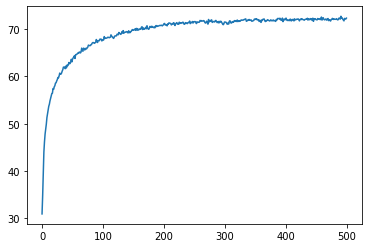

In [118]:
plt.plot(acc_test_arr)
plt.show()

In [122]:
import pickle

filename = './results_CIFAR/FedAvg_N40_m10_A0_'
outfile = open(filename,'wb')

pickle.dump(acc_test_arr,outfile)
outfile.close()